# Temporal Difference (TD) Actor-Critic

## Implementation for MiniHack Quest-Hard environment

# Setup

Skip this step if the MiniHack environment is already running on your machine.

In [ ]:
!sudo apt update
!sudo apt install -y build-essential autoconf libtool pkg-config python3-dev \
    python3-pip python3-numpy git flex bison libbz2-dev

!wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add -
!sudo apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main'
!sudo apt-get update && apt-get --allow-unauthenticated install -y \
    cmake \
    kitware-archive-keyring

# feel free to use a more elegant solution to make /usr/bin/cmake the default one
!sudo rm $(which cmake)
!$(which cmake) --version

# -v can be dropped unless you run into some other trouble
!pip3 install -Uv nle
!pip install minihack 
!pip install gym[box2d]

#For Video
!pip install imageio-ffmpeg

Make sure to run this in bash terminal before executing code: 
**export LD_LIBRARY_PATH=\\$LD_LIBRARY_PATH:\$CONDA_PREFIX/lib/**

In [ ]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

## Imports

In [11]:
#Agent Imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

#Network Imports
import os 
import tensorflow.keras as keras 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ReLU
from tensorflow_lattice.python.linear_layer import Linear
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#Run Actor Critic Imports
import gym
import nle
import numpy as np
import time

#MiniHack Environment Imports
import minihack
from nle import nethack

#Imports for video generation
import glob
from gym.wrappers.monitoring import video_recorder
import moviepy
import moviepy.video.io.ImageSequenceClip


# Implementation

## Network (Model)

In [28]:
class ActorCriticNetwork(keras.Model):
    def __init__(self,n_actions, fc1_dims=1024, fc2_dims=512,
                name = 'actor_critic', chkpt_dir='tmp/actor_critic'):
        super(ActorCriticNetwork,self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions 
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ac')
        
        
        # === Layers for Glpyhs Observation =====
        
        #2 Fully connected layers 
        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation ='relu')
        
        # Convolutional Layers
        self.conv1 = Conv2D(20,kernel_size=(5, 5), activation='relu')
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.conv2 = Conv2D(50,kernel_size=(5, 5), activation='relu')
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        
        # === Layers for Message Observation =====
        self.linear1 = Linear(256)
        self.relu1 = ReLU()
        
        # === Layers for Concatenated Observations =====
        self.linear2 = Linear(513)
        self.relu2 = ReLU()
        
        self.v = Dense(1, activation = None) #Used to return value function from network
        self.pi = Dense(n_actions, activation='softmax') #Used to return policy from network
        
    #Feed forward function
    def call(self, state):
        
        #Convert to float
        state_glyph = np.array(state["glyphs"]).astype('float32')
        state_message = np.array(state["message"]).astype('float32')
        
        #Format glyphs observation for layers
        glyphs = tf.convert_to_tensor(state_glyph)
        glyphs = tf.expand_dims(glyphs, axis=0)
        glyphs = tf.expand_dims(glyphs, axis=-1)
        
        #Format message observation for layers
        message = tf.convert_to_tensor(state_message)
        message = tf.expand_dims(message, axis=0)
        
        
        #Feed glyphs observation through network layers
        glyphs = self.conv1(glyphs)
        glyphs = self.maxpool1(glyphs)
        glyphs = self.conv2(glyphs)
        glyphs = self.maxpool2(glyphs)
        
        glyphs = glyphs.reshape(glyphs.shape[0], -1) #Flatten output from previous layer to pass to fully connected layer
        glyphs = self.fc1(glyphs)
        glyphs = self.fc2(glyphs)
        
        #Feed message observation through network layers
        message = self.linear1(message)
        message = self.relu1(message)
        
        #Concatenate observation outputs
        combined = Concatenate(axis=1)([glyphs,message])
        
        #Feed concatenation through network layers
        combined = self.linear2(combined)
        combined = self.relu2(combined)
        
        #Produce value and policy
        v = self.v(combined)
        pi = self.pi(combined)
        
        return v, pi

#Source: https://youtu.be/LawaN3BdI00

## Agent

In [29]:
class Agent:
    def __init__(self, alpha=0.0003, gamma=0.99,n_actions=2):
        self.gamma = gamma
        self.n_actions = n_actions
        self.action = None #Keeps track of last action taken
        self.action_space = [i for i in range(self.n_actions)]
        
        self.actor_critic = ActorCriticNetwork(n_actions=n_actions)
        
        self.actor_critic.compile(optimizer=Adam(learning_rate=alpha))
        
    def choose_action(self, observation):
        _, probs = self.actor_critic(observation)
        action_probability = tfp.distributions.Categorical(probs=probs)
        action = action_probability.sample()
        self.action = [action[0]]
        return action.numpy()[0]
        
    def learn(self, state, reward, state_,done):
        
        reward = tf.convert_to_tensor(reward,dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            state_value, probs = self.actor_critic(state)
            state_value_, _ = self.actor_critic(state_)
            state_value = tf.squeeze(state_value)
            state_value_ = tf.squeeze(state_value_)
            
            action_probs = tfp.distributions.Categorical(probs=probs)
            log_prob = action_probs.log_prob(self.action)
            
            #Calculate TD Error
            delta = (reward + self.gamma*state_value_*(1-int(done))) - state_value
            
            #Combine TD Error into an actor and critic loss
            actor_loss = -log_prob*delta
            critic_loss = delta**2
            total_loss = actor_loss + critic_loss
            
            #Update gradients in the network
            gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
            self.actor_critic.optimizer.apply_gradients(zip(gradient,self.actor_critic.trainable_variables))

## Main

In [33]:
def runActorCritic(keys=None, learning_rate=5e-6, num_games=2):
    
    #Constrain the action space
    MOVE_ACTIONS = tuple(nethack.CompassDirection)
    NAVIGATE_ACTIONS = MOVE_ACTIONS + (
        nethack.Command.OPEN,
        nethack.Command.KICK,
        nethack.Command.SEARCH,
    )
    
    env = gym.make("MiniHack-Quest-Hard-v0",
        actions=NAVIGATE_ACTIONS, 
        observation_keys=(["glyphs","message", "pixel"])
    )
    

    agent = Agent(alpha=learning_rate,n_actions=env.action_space.n)
    n_games = num_games

    best_score = env.reward_range[0]
    bestVidFrames = []
    score_history = []
    
    start = time.time()
    for i in range(n_games):
        vidFrames = [] #initialise frames to empty array
        print(f'====== Episode {i} ======')
        observation = env.reset()
        #print(observation["message"])
        done = False
        score = 0
        while not done:
            vidFrames.append(observation['pixel'])
            action = agent.choose_action(observation) 
            observation_,reward, done,info = env.step(action)
            score+=reward
            agent.learn(observation, reward, observation_ , done)
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        env.render()
        if avg_score > best_score:
            print('Better Avg Score')
            best_score = avg_score
            bestVidFrames = vidFrames
        print('episode ',i,' ~ score %.1f ~ ' % score, 'avg_Score %.1f' % avg_score)
    x = [i+1 for i in range(n_games)]
    end = time.time()
    print(f'Time taken: {(end - start)/60} mins')
    return x, score_history, bestVidFrames

In [34]:
x, score_history, vidFrames = runActorCritic(num_games=200)

bash: /home/rxrider/anaconda3/envs/gpu2/lib/libtinfo.so.6: no version information available (required by bash)
/home/rxrider/anaconda3/envs/gpu2/lib/python3.7/site-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments


====== Episode 0 ======

                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu quit in The Dungeons of Doom on            
                                                                                
              level 1.                                                8  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
   


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law quit in The Dungeons of Doom on            
                                                                                
              level 1.                                                3  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking the stairs.                 -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law quit in The Dungeons of Doom on            
                                                                                
              level 1.                                                6  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu quit in The Dungeons of Doom on            
                                                                                
              level 1.                                                4  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking the stairs.                 -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Neu died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           


                                                                                
 No  Points     Name                                                   Hp [max] 
                                                                                
            0  Agent-Cav-Hum-Mal-Law died in The Dungeons of Doom on            
                                                                                
              level 1.  Killed by kicking a wall.                     -  [16]   
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           

## Results

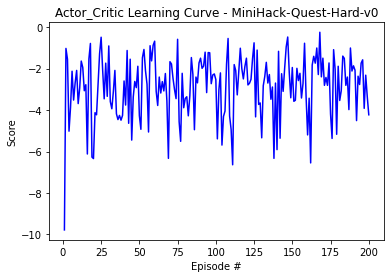

In [36]:
# Plot learning curve
import matplotlib.pyplot as plt 

plt.title('Actor_Critic Learning Curve - MiniHack-Quest-Hard-v0')
plt.plot(x, score_history,color='blue',  label='Score')

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

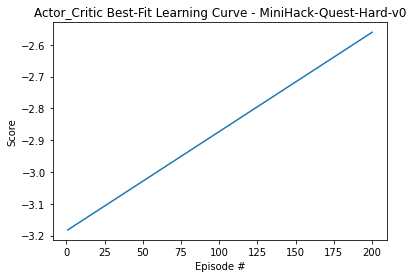

In [47]:
#Find line of best fit
a, b = np.polyfit(x, score_history, 1)

plt.title('Actor_Critic Best-Fit Learning Curve - MiniHack-Quest-Hard-v0')

plt.ylabel('Score')
plt.xlabel('Episode #')

#Add line of best fit to plot
plt.plot(x, a*np.array(x)+b)   

plt.show()

## Generate Video Sequence

In [37]:
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(vidFrames, fps=30)
clip.write_videofile("./bestRun_ACTORCRITIC.mp4", fps=30) 

Moviepy - Building video ./bestRun_ACTORCRITIC.mp4.
Moviepy - Writing video ./bestRun_ACTORCRITIC.mp4



TypeError: must be real number, not NoneType